In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

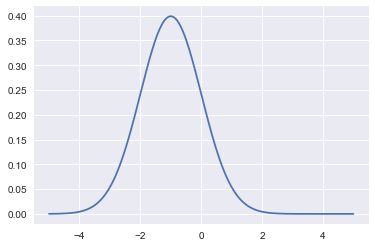

In [3]:
mu, sigma = -1, 1
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, norm.pdf(xs, loc = mu, scale = sigma))

In [4]:
train_iters = 10000
batch_size = 200

In [5]:
# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [6]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        train_iters // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate, 0.6).minimize(loss, global_step=batch,var_list=var_list)
    return optimizer

In [7]:
with tf.variable_scope("D_pretrain"):
    input_node=tf.placeholder(tf.float32, shape=(batch_size,1))
    train_labels=tf.placeholder(tf.float32,shape=(batch_size,1))
    D, theta = mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D - train_labels))

In [8]:
optimizer=momentum_optimizer(loss, None)

In [9]:
sess = tf.InteractiveSession()

In [10]:
tf.global_variables_initializer().run()

In [11]:
# plot the decision surface
def plot_d0(D, input_node):
    f, ax = plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label = 'p_data')
    
    # decision boundary
    r = 1000 # resolution (number of points)
    xs = np.linspace(-5, 5, r)
    ds = np.zeros((r, 1)) # decision surface
    # process multiple points in parallel in a minibatch
    batch_count = int(r / batch_size)
    for i in range(batch_count):
        x = np.reshape(xs[batch_size * i : batch_size * (i+1)], (batch_size, 1))
        ds[batch_size * i: batch_size * (i + 1)] = sess.run(D, {input_node : x})
        
    ax.plot(xs, ds, label = 'decision boundary')
    ax.set_ylim(0, 1.1)
    plt.legend()

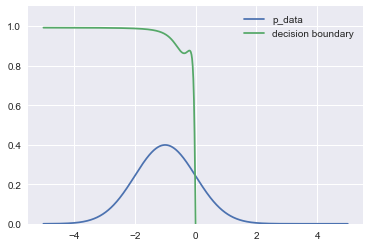

In [12]:
plot_d0(D, input_node)

In [13]:
lh = np.zeros(1000)
for i in range(1000):
    d = (np.random.random(batch_size) - 0.5) * 10.0
    labels = norm.pdf(d, loc = mu, scale = sigma)
    lh[i], _= sess.run([loss, optimizer], 
                       {input_node: np.reshape(d, (batch_size, 1),), 
                        train_labels: np.reshape(labels, (batch_size, 1))})

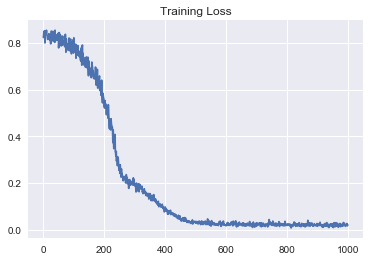

In [14]:
plt.plot(lh)
plt.title('Training Loss')

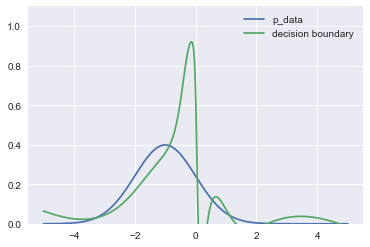

In [15]:
plot_d0(D, input_node)

In [16]:
# copy the learned weights over into a temp array
weightsD = sess.run(theta)

In [17]:
sess.close()

In [18]:
# Now build the actual generative adversarial network
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape=(batch_size, 1))
    G, theta_g = mlp(z_node, 1) # generate normal transformation of z
    G = tf.multiply(5.0, G) # scale up by 5 to match range
with tf.variable_scope("D") as scope:
    # D(x)
    x_node = tf.placeholder(tf.float32, shape = (batch_size, 1))
    fc, theta_d = mlp(x_node, 1)
    D1 = tf.maximum(tf.minimum(fc, 0.99), 0.01)
    scope.reuse_variables()
    fc, theta_d = mlp(G, 1)
    D2 = tf.maximum(tf.minimum(fc, 0.99), 0.01)
obj_d = tf.reduce_mean(tf.log(D1) + tf.log(1 - D2))
obj_g = tf.reduce_mean(tf.log(D2))

# set up optimizer for G, D
opt_d = momentum_optimizer(1 - obj_d, theta_d)
opt_g = momentum_optimizer(1 - obj_g, theta_g)

In [19]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [20]:
# copy weights from pre-training over to new D network
for i, v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [21]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(int(r / batch_size)):
        x=np.reshape(xs[batch_size*i:batch_size*(i+1)],(batch_size,1))
        ds[batch_size*i:batch_size*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(int(r/batch_size)):
        z=np.reshape(zs[batch_size*i:batch_size*(i+1)],(batch_size,1))
        gs[batch_size*i:batch_size*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

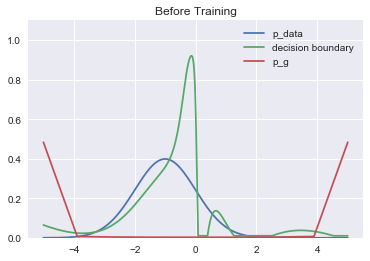

In [22]:
# initial conditions
plot_fig()
plt.title('Before Training')

In [23]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histd, histg= np.zeros(train_iters), np.zeros(train_iters)
for i in range(train_iters):
    for j in range(k):
        x= np.random.normal(mu,sigma,batch_size) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,batch_size)+np.random.random(batch_size)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], 
                            {x_node: np.reshape(x,(batch_size,1)), 
                             z_node: np.reshape(z,(batch_size,1))})
    z= np.linspace(-5.0,5.0,batch_size)+np.random.random(batch_size)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(batch_size,1))}) # update generator
    if i % (train_iters//10) == 0:
        print(float(i)/float(train_iters))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


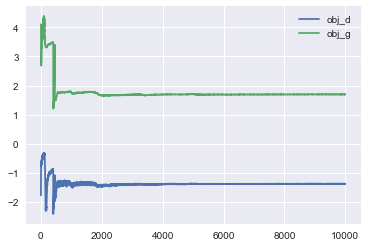

In [24]:
plt.plot(range(train_iters),histd, label='obj_d')
plt.plot(range(train_iters), 1-histg, label='obj_g')
plt.legend()

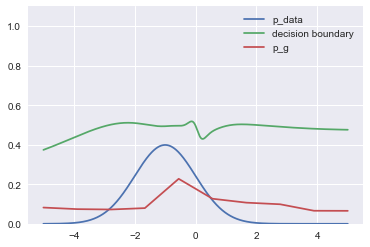

In [25]:
plot_fig()

In [26]:
'''
http://blog.evjang.com/2016/06/generative-adversarial-nets-in.html
https://blog.waya.ai/introduction-to-gans-a-boxing-match-b-w-neural-nets-b4e5319cc935#.xvnt1n5i7
https://medium.com/@ageitgey/abusing-generative-adversarial-networks-to-make-8-bit-pixel-art-e45d9b96cee7#.h5hk4muw6
https://openai.com/blog/generative-models/
''' 